In [21]:
import pandas as pd
import requests
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve as skroc
%matplotlib inline 
import numpy as np

In [2]:
def get_data(filename):
    '''
    Input: file path of training data
    Output: dataframe of training data
    '''
    df = pd.read_json(filename)
    return df

In [3]:
def clean_data_get_Xy(df, cols_to_drop):
    '''
    Input: dataframe, list of columns to drop from dataframe
    Output: X, y matrices to fit any model. Fraud target column is added to the datframe, specified columns are dropped, NaNs are filled, prior to creating X, y matrices
    '''
    # add fraud target column
    fraud_mask = (df.loc[:, 'acct_type'] == 'fraudster_event') | (df.loc[:, 'acct_type'] == 'fraudster') | (df.loc[:, 'acct_type'] == 'fraudster_att')
    df.loc[fraud_mask, 'fraud'] = 1
    df['fraud'].fillna(0, inplace=True)

    # drop cols_to_drop columns and fill NaNs with 0
    df.drop(cols_to_drop, axis=1, inplace=True)
    df.fillna(0, inplace=True)

    # create X, y matrices to fit model
    X = df.drop('fraud', axis=1).values
    y = df['fraud'].values

    return X, y

In [4]:
fraud_df = get_data('data/data.json')

In [5]:
cols_to_drop = ['acct_type', 'approx_payout_date', 'channels', 'country', 'currency', 'delivery_method', 'description', 'email_domain', 'event_created', 'event_end', 'event_published', 'event_start', 'name', 'object_id', 'org_desc', 'org_name','payee_name', 'payout_type', 'previous_payouts', 'sale_duration2', 'ticket_types','user_created', 'user_type', 'venue_address', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state', 'listed', 'gts', 'num_order', 'num_payouts']
X, y = clean_data_get_Xy(fraud_df, cols_to_drop)

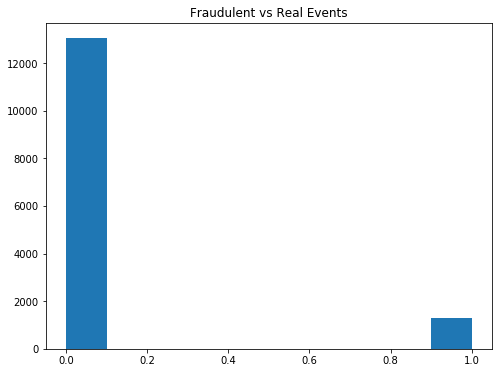

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist(fraud_df['fraud'])
ax.set_title('Fraudulent vs Real Events')
plt.savefig('imgs/fraud_hist.png');

In [33]:
# Log-Reg
# standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# get train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

'''LOGISTIC REGRESSION'''
# fit a logistic regression model
log_reg_model = LogisticRegression(max_iter=5000, n_jobs=-1, verbose=2, class_weight='balanced')
log_reg_model.fit(X_train, y_train)
probabilities = log_reg_model.predict_proba(X_test)[:, 1]
tpr, fpr, thresholds = skroc(y_test, probabilities)

# predict and print results
#     print(log_reg_model.score(X_test, y_test))
lin_preds = log_reg_model.predict(X_test)
precision = precision_score(y_test, lin_preds)
recall = recall_score(y_test, lin_preds)
#     print(f'Precision={precision:.3f}  Recall={recall:.3f}')


'''RANDOM FOREST'''
rf_model = RandomForestClassifier(n_estimators=500, criterion="gini", max_depth=None, min_samples_split=4, min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features="auto", max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight="balanced")
rf_model.fit(X_train, y_train)

# predict and print results
rf_preds = rf_model.predict(X_test)
acc = rf_model.score(X_test, y_test)
probs = rf_model.predict_proba(X_test)[:, 1]
tprf, fprf, thresholdsf = skroc(y_test, probs)

/Users/alanteran/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

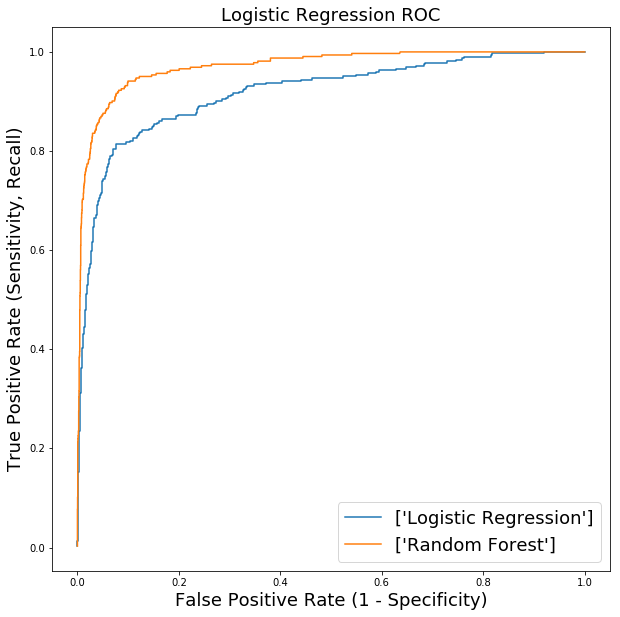

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(tpr, fpr, label=['Logistic Regression'])
ax.plot(tprf, fprf, label=['Random Forest'])
ax.set_xlabel("False Positive Rate (1 - Specificity)", fontsize=18)
ax.set_ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=18)
ax.set_title("Logistic Regression ROC", fontsize=18)
ax.legend(fontsize=18);
